In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
#path_data = os.path.dirname(__file__) # no funciona en jupyter
path_data = os.path.abspath('')
path_data

'/home/pjcopado/code/juanpedrobesenyi/cyberbullying/notebooks/pjcopado'

In [4]:
path_raw_data = os.path.join(path_data, '../../raw_data/')
path_raw_data

'/home/pjcopado/code/juanpedrobesenyi/cyberbullying/notebooks/pjcopado/../../raw_data/'

In [5]:
file_names = os.listdir(path=path_raw_data)
files = [file for file in file_names if file.endswith('.csv')]
files

['toxicity_parsed_dataset.csv',
 'aggression_parsed_dataset.csv',
 'twitter_parsed_dataset.csv',
 'twitter_racism_parsed_dataset.csv',
 'twitter_sexism_parsed_dataset.csv',
 'youtube_parsed_dataset.csv',
 'kaggle_parsed_dataset.csv']

In [6]:
files = {file.replace('_parsed', '').replace('_dataset','').replace('.csv',''): file for file in file_names if file.endswith('.csv')}
files

{'toxicity': 'toxicity_parsed_dataset.csv',
 'aggression': 'aggression_parsed_dataset.csv',
 'twitter': 'twitter_parsed_dataset.csv',
 'twitter_racism': 'twitter_racism_parsed_dataset.csv',
 'twitter_sexism': 'twitter_sexism_parsed_dataset.csv',
 'youtube': 'youtube_parsed_dataset.csv',
 'kaggle': 'kaggle_parsed_dataset.csv'}

In [7]:
data = {name: pd.read_csv(path_raw_data+file, usecols=['Text', 'oh_label']) for name, file in files.items()}
for name, dataset in data.items():
    dataset.rename(columns={'Text': 'text', 'oh_label':'target'}, inplace=True)
    data[name] = data[name][['text', 'target']]
    #dataset['source'] = files_tag[name]

In [8]:
data.keys()

dict_keys(['toxicity', 'aggression', 'twitter', 'twitter_racism', 'twitter_sexism', 'youtube', 'kaggle'])

In [9]:
#df = pd.concat([dataset for dataset in data.values()], ignore_index=True)
#df

In [10]:
#file = 'toxicity_parsed_dataset.csv'
#df = pd.read_csv(path_raw_data+file, usecols=['Text', 'oh_label'])
#df.rename(columns={'Text':'text', 'oh_label':'target'}, inplace=True)
#df.head()

In [11]:
text = '@hello how are you?'

regex = r'@\w+'

re.sub(regex, '', text, flags=re.IGNORECASE)

' how are you?'

In [12]:
def remove_twitt_name(text):
    regex = r'^@\w+'
    return re.sub(regex, '', text, flags=re.IGNORECASE)

In [49]:
def remove_twitt_rt(text):
    regex = r'RT[\s]+'
    return re.sub(regex, '', text, flags=re.IGNORECASE)

In [13]:
def remove_duplicated_words(text):
    regex = r'\b(\w+)(?:\W+\1\b)+' 
    return re.sub(regex, r'\1', text, flags=re.IGNORECASE)

In [14]:
text = 'asd asd asd hello asd hello asd hello'

In [15]:
remove_duplicated_words(text)

'asd hello asd hello asd hello'

In [16]:
def remove_duplicated_phrase(text):
    regex = r'\b(\w+(?:\s*\w*))\s+\1\b'
    return re.sub(regex, "\\1", text, flags=re.IGNORECASE)

In [17]:
remove_duplicated_phrase(remove_duplicated_words(remove_duplicated_phrase(text)))

'asd hello'

In [18]:
def remove_duplicates_phrases(text):
    for n in range(2):
        regex = r'\b(\w+)(?:\W+\1\b)+' 
        text = re.sub(regex, r'\1', text, flags=re.IGNORECASE)
        regex = r'\b(\w+(?:\s*\w*))\s+\1\b'
        text =  re.sub(regex, "\\1", text, flags=re.IGNORECASE)
    return text

In [19]:
remove_duplicates(text)

'asd hello'

In [20]:
def remove_dup(text):
    regex = r'\b(\w+)(?:\W+\1\b)+|\b(\w+(?:\s*\w*))\s+\1\b' 
    return re.sub(regex, "\\1", text, flags=re.IGNORECASE)

In [21]:
remove_dup(text)

'asd hello asd hello asd hello'

In [22]:
type(data)

dict

In [23]:
type(data['toxicity'])

pandas.core.frame.DataFrame

In [24]:
isinstance(data['toxicity'], pd.DataFrame)

True

In [25]:
def clean_data(text,
               remove_punctuation=True,
               lower_text=True,
               remove_numbers=True,
               remove_stopwords=False, 
               lemmatize=False):
    
    text = str(text)
    
    # remove twitter names
    text = remove_twitt_name(text)
    text = remove_twitt_rt(text)
    
    # replace emojis with text
    #text = demoji.replace_with_desc(text, ' ')
    
    # keep only letters
    if remove_punctuation:
        text = re.sub(r'[^a-zA-Z]+', ' ', text)
    
    # lower text
    if lower_text:
        text = text.lower()
    
    # remove numbers
    if remove_numbers:
        text = ''.join([w for w in text if not w.isdigit()])
    
    # remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        #word_tokens = word_tokenize(text)
        #text = ' '.join([w for w in word_tokens if not w in stop_words])
    
    # lemmatize
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        #text = ''.join([lemmatizer.lemmatize(word) for word in text]) # no entiendo por qué no va un espacio
    
    # spam
    #text = remove_duplicated_words(text)
    text = remove_duplicates_phrases(text)
    
    text = text.strip()
    
    return text

In [26]:
def clean_df(df, 
            remove_punctuation=True,
            lower_text=True,
            remove_numbers=True,
            remove_stopwords=False, 
            lemmatize=False):
    
    df = df.copy()
    
    df = df.drop_duplicates()
    
    df['text'] = df['text'].apply(lambda text: clean_data(text,
                                                          remove_punctuation,
                                                          lower_text,
                                                          remove_numbers,
                                                          remove_stopwords,
                                                          lemmatize))
    
    df = df.drop_duplicates()
    
    df = df.replace(['', ' '], np.nan)
    df = df.dropna().reset_index(drop=True)
    
    return df

In [27]:
%%time

for name in data.keys():
    data[name] = clean_df(data[name])

CPU times: user 1min 20s, sys: 87.8 ms, total: 1min 20s
Wall time: 1min 20s


In [28]:
data['toxicity']

,text,target
0,this one can make an analogy in mathematical t...,0
1,clarification for you and zundark s right i sh...,0
2,elected or electoral jhk,0
3,this is such a fun entry devotchka i once had ...,0
4,please relate the ozone hole to increases in c...,0
...,...,...
157376,these sources don t exactly exude a sense of i...,0
157377,the institute for historical review is a peer ...,0
157378,the way you re trying to describe it in this a...,0
157379,warning there is clearly a protectionist regim...,0


In [29]:
%%time

#df = clean_df(df)
#df.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [30]:
#df.shape

In [31]:
data.keys()

dict_keys(['toxicity', 'aggression', 'twitter', 'twitter_racism', 'twitter_sexism', 'youtube', 'kaggle'])

In [32]:
def plot_hist(X):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    len_ = [len(_.split()) for _ in X]
    ax1.hist(len_)
    ax1.set_title('All length')
    
    n = 400
    
    len_2 = [_ for _ in len_ if _ < n]
    ax2.hist(len_2)
    ax2.set_title(f'Only ≤ {n} words')
    
    plt.suptitle('Histogram of the number of sentences that have a given number of words')
    plt.tight_layout(pad=1)
    plt.show()

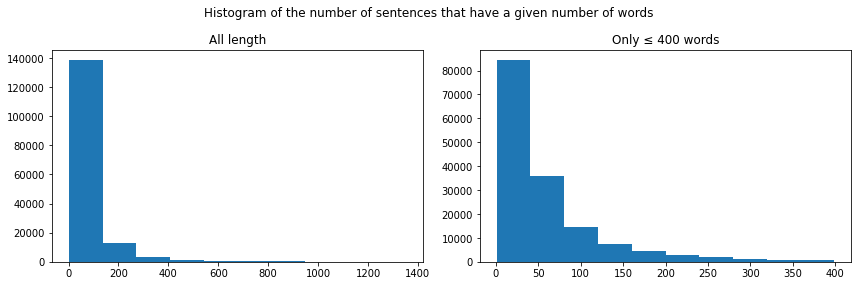

In [33]:
plot_hist(data['toxicity']['text'])

In [34]:
data['toxicity'][data['toxicity']['text'].map(lambda text: len(text.split())) <=1000]

,text,target
0,this one can make an analogy in mathematical t...,0
1,clarification for you and zundark s right i sh...,0
2,elected or electoral jhk,0
3,this is such a fun entry devotchka i once had ...,0
4,please relate the ozone hole to increases in c...,0
...,...,...
157376,these sources don t exactly exude a sense of i...,0
157377,the institute for historical review is a peer ...,0
157378,the way you re trying to describe it in this a...,0
157379,warning there is clearly a protectionist regim...,0


In [35]:
for name in data.keys():
    data[name] = data[name][data[name]['text'].map(lambda text: len(text.split())) <=1000]

In [36]:
#df = df[df['text'].map(lambda text: len(text.split())) <=1000].reset_index(drop=True)

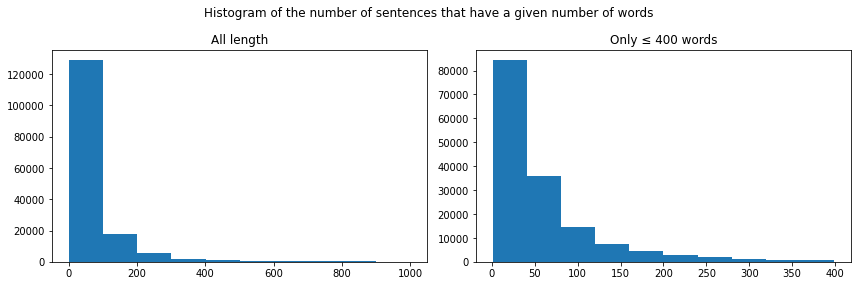

In [37]:
plot_hist(data['toxicity']['text'])

In [38]:
#plot_hist(df['text'])

In [39]:
df = pd.concat([dataset for dataset in data.values()], ignore_index=True).drop_duplicates().reset_index(drop=True)
df.head()

,text,target
0,this one can make an analogy in mathematical t...,0.0
1,clarification for you and zundark s right i sh...,0.0
2,elected or electoral jhk,0.0
3,this is such a fun entry devotchka i once had ...,0.0
4,please relate the ozone hole to increases in c...,0.0


In [40]:
for name, file in files.items():
    data[name].to_csv(f'../../cyberbullying/data/{file}', index=False)
df.to_csv(f'../../cyberbullying/data/all_df.csv', index=False)

In [41]:
%%time

for name in data.keys():
    data[name] = clean_df(data[name],
                          remove_punctuation=False,
                          lower_text=False,
                          remove_numbers=False,
                          remove_stopwords=True,
                          lemmatize=True)

CPU times: user 1min 34s, sys: 1.64 s, total: 1min 35s
Wall time: 1min 35s


In [42]:
df = pd.concat([dataset for dataset in data.values()], ignore_index=True).drop_duplicates().reset_index(drop=True)
df.head()

,text,target
0,this one can make an analogy in mathematical t...,0.0
1,clarification for you and zundark s right i sh...,0.0
2,elected or electoral jhk,0.0
3,this is such a fun entry devotchka i once had ...,0.0
4,please relate the ozone hole to increases in c...,0.0


In [43]:
for name, file in files.items():
    data[name].to_csv(f'../../cyberbullying/data/lem_{file}', index=False)
df.to_csv(f'../../cyberbullying/data/lem_all_df.csv', index=False)

In [44]:
#df.to_csv('../../cyberbullying/data/all_data.csv', index=False)

In [45]:
#%%time
#df_lem = clean_df(df, remove_punctuation=False, lower_text=False, remove_numbers=False, remove_stopwords=True, lemmatize=True)
#df_lem.head()

In [46]:
#df_lem.shape

In [47]:
#df_lem.to_csv('../../cyberbullying/data/all_data_lem.csv', index=False)